In [1]:
!pip install -q opencv-python matplotlib


You should consider upgrading via the '/Users/filipporeucci/oilSpotRecognition/myvenv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os, cv2, csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cv2 import GaussianBlur
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
#from image_hclustering import clusterMatrixMain

In [3]:
def plot_histogram(image_path):    
    ddepth = cv2.CV_16S
    kernel_size = 3
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load an image

    image = cv2.GaussianBlur(image, (3, 3), 0) # Apply Gaussian Blur - reduce noise
    
    dst = cv2.Laplacian(image, ddepth, ksize=kernel_size) # Apply Laplace function
    
    abs_dst = cv2.convertScaleAbs(dst) # Converting back to uint8
    
    hist_gray = cv2.calcHist([abs_dst], [0], None, [256], [0, 256]) # Calculate histogram
    return hist_gray

In [4]:
def getSSIM(image1_path,image2_path):
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE) # Load an image
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE) # Load an image

    return ssim(image1, image2, full=True)


In [5]:
def getLabel(image1,image2):
     # Extract label from image name file
    image1 = image1.split("_")[1].split(".")[0]
    image2 = image2.split("_")[1].split(".")[0]
    label = "_".join(sorted([image1, image2]))
    return label

In [6]:
#Creating distance matrix between the histograms contained in the directory
def features_extraction(histograms_list, image_files, folder_path):
    image_files = str(image_files)
    #pathImages = os.path(image_files)
    featuresFile = []
    
    # Calculating distance between images histograms
    for i in range(len(histograms_list)):
        for j in range(i, len(histograms_list)):
            image1, hist1 = histograms_list[i]
            image2, hist2 = histograms_list[j]
            
            total_distance = 0
            #total_distance += cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL) 
            total_distance +=  cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA) # Distance between histograms
            #total_distance = 1 - total_distance    # Distance = 0 means images are equals
            
            if image1 != image2:
                ssim_score = getSSIM(os.path.join(folder_path, image1), os.path.join(folder_path, image2))
                label = getLabel(image1,image2)
                featuresFile.append([image1, image2, total_distance, round(ssim_score[0], 2), label])
                
    return featuresFile 

In [7]:
#Process the images in a directory creating histogram and distance matrix
def process_images_from_folder(folder_path):
    if not os.path.exists(folder_path):
        print("Error: Specified folder does not exists.")
        return None
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'webp', 'tiff'))]
    if not image_files:
        print("No images found in the folder.")
        return None
    
    histograms_list = []
    for image_file in image_files: 
        image_path = os.path.join(folder_path, image_file)
        hist = plot_histogram(image_path)  
        histograms_list.append((image_file, hist))
        #label.append([image_file, image_file.split("_")[1].split(".")[0]]) # Creating label record for labels.csv file
    
    features = features_extraction(histograms_list, image_files, folder_path)

    return features


In [8]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn import metrics
import os


def clusterMatrixMain(total_distance_matrix_path,total_labels_path):
    # Path of the total distance matrix
    distance_matrix = pd.read_csv(total_distance_matrix_path, sep=",", header=None, index_col=None)
    labels = pd.read_csv(total_labels_path, sep=",")

    distance_matrix = distance_matrix.drop(index=distance_matrix.index[0], columns=distance_matrix.columns[0])
    n_clusters = 3
    
    # Read the true lables assigned to every Id 
    labels_true = list(labels["Label"])
    
    # Execute clustering with single linkage and determines the predicted labels for each molecule
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage ='single').fit(distance_matrix)

    labels_pred = model.fit_predict(distance_matrix)

    # Compute the metrics and print the evaluations
    print("Method: single")
    print("Rand_score", metrics.rand_score(labels_true, labels_pred))
    print("Homogeneity_score", metrics.homogeneity_score(labels_true, labels_pred))
    print("Completeness_score", metrics.completeness_score(labels_true, labels_pred))
        
    # Execute clustering with complete linkage and determines the predicted labels for each molecule

    model = AgglomerativeClustering(n_clusters=n_clusters, linkage ='complete').fit(distance_matrix)
    labels_pred = model.fit_predict(distance_matrix)

    # Compute the metrics and print the evaluations
    print("Method: complete")
    print("Rand_score", metrics.rand_score(labels_true, labels_pred))
    print("Homogeneity_score", metrics.homogeneity_score(labels_true, labels_pred))
    print("Completeness_score", metrics.completeness_score(labels_true, labels_pred))


    # Execute clustering with average linkage and determines the predicted labels for each molecule

    model = AgglomerativeClustering(n_clusters=n_clusters, linkage ='average').fit(distance_matrix)
    labels_pred = model.fit_predict(distance_matrix)

    # Compute the metrics and print the evaluations
    print("Method: average")
    print("Rand_score", metrics.rand_score(labels_true, labels_pred))
    print("Homogeneity_score", metrics.homogeneity_score(labels_true, labels_pred))
    print("Completeness_score", metrics.completeness_score(labels_true, labels_pred))


In [9]:
folder_path = "datasetSuddiviso"
subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
total_distance_matrix = None
total_features = []

for subfolder in subfolders: 
    subfolder_path = os.path.join(folder_path, subfolder)
    features = process_images_from_folder(subfolder_path) # Distance matrix between images in the subfolder 
    
    total_features.extend(features)

total_features_path = os.path.join(folder_path, "features.csv")

pd.DataFrame(total_features, columns=["Image1", "Image2", "Histogram_Distance","SSIM", "Label"]).to_csv(total_features_path,index=False)

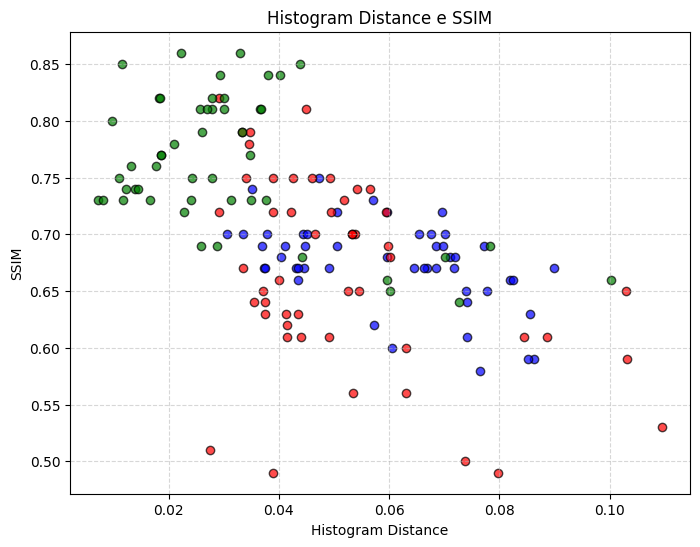

In [14]:
df_features = pd.read_csv(total_features_path, sep=",",skiprows=0 )
df_perdite_pulite = df_features[df_features["Label"] == "PERDITE_PULITE"]
df_pulite_vergine = df_features[df_features["Label"] == "PULITE_VERGINE"]
df_perdite_vergine = df_features[df_features["Label"] == "PERDITE_VERGINE"]

plt.figure(figsize=(8, 6))  
plt.scatter(df_perdite_pulite["Histogram_Distance"], df_perdite_pulite["SSIM"], color="blue", alpha=0.7, edgecolors="k")
plt.scatter(df_pulite_vergine["Histogram_Distance"], df_pulite_vergine["SSIM"], color="red", alpha=0.7, edgecolors="k")
plt.scatter(df_perdite_vergine["Histogram_Distance"], df_perdite_vergine["SSIM"], color="green", alpha=0.7, edgecolors="k")

plt.xlabel("Histogram Distance")
plt.ylabel("SSIM")
plt.title("Histogram Distance e SSIM")

# Aggiungi griglia
plt.grid(True, linestyle="--", alpha=0.5)

# Mostra il grafico
plt.show()

In [ ]:
'''from ClusterFeatures import clusterFeatures
print (total_features_path)
features = pd.read_csv(total_features_path, sep=",")
print(features.columns)
clusterFeatures(total_features_path)'''

datasetSuddiviso/features.csv
Index(['Image1', 'Image2', 'Histogram_Distance', 'SSIM', 'Label'], dtype='object')
Index(['Image1', 'Image2', 'Histogram_Distance', 'SSIM', 'Label'], dtype='object')
                Image1             Image2  Histogram_Distance  SSIM  \
0     UVG21_PULITE.png  UVG21_PERDITE.png            0.068560  0.67   
1     UVG21_PULITE.png  UVG21_VERGINE.png            0.053809  0.70   
2    UVG21_PERDITE.png  UVG21_VERGINE.png            0.018521  0.77   
3    UVG26_VERGINE.png   UVG26_PULITE.png            0.042563  0.75   
4    UVG26_VERGINE.png  UVG26_PERDITE.png            0.027790  0.81   
..                 ...                ...                 ...   ...   
145  UVG36_VERGINE.png   UVG36_PULITE.png            0.059754  0.69   
146  UVG36_PERDITE.png   UVG36_PULITE.png            0.085495  0.63   
147   UVG38_PULITE.png  UVG38_PERDITE.png            0.077683  0.65   
148   UVG38_PULITE.png  UVG38_VERGINE.png            0.049519  0.72   
149  UVG38_PERDITE.png 

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'